In [1]:
%load_ext google.cloud.bigquery

In [2]:
import os
import json
import pandas as pd
from google.oauth2 import service_account
from google.cloud import bigquery, storage
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt

In [5]:
bigquery_client=bigquery.Client()

In [6]:
%%bigquery
WITH Primary_Care_Shortage AS (
  SELECT *
  FROM `bigquery-public-data.sdoh_hrsa_shortage_areas.hpsa_primary_care` 
  WHERE HPSA_Withdrawn_Date IS NULL AND Common_State_Abbr = "TX"
  ORDER BY County_Name
)
 
SELECT * FROM Primary_Care_Shortage ORDER BY HPSA_Score DESC

Downloading: 100%|████████████████████████████████████████████████████████████████| 955/955 [00:01<00:00, 855.83rows/s]


,Source_ID,Source_Name,Status_Code,Status_Description,Type_Code,Type_Desc,Address,City,State_Abbr,Postal_Code,...,Common_State_Name,Common_State_FIPS,Common_Region_Name,HPSA_Withdrawn_Date,HPSA_Withdrawn_Date_String,Provider_Type,Rural_Status_Code,Rural_Status_Desc,HPSA_Designation_Pop_Type_Desc,BHCMIS_OrgID
0,14899948J1,TEXAS TECH UNIVERSITY HEALTH SCIENCES CENTER,D,Designated,FQHC,Federally Qualified Health Center,3601 4th St Ms 6271,Lubbock,TX,79430-0001,...,Texas,48,Region VI,None,None,None,N,Non-Rural,Federally Qualified Health Center,6.00E+41
1,148999485U,"Community Health Center Of Lubbock, Inc., The",D,Designated,FQHC,Federally Qualified Health Center,1610 5th St,Lubbock,TX,79401-2622,...,Texas,48,Region VI,None,None,None,N,Non-Rural,Federally Qualified Health Center,62910
2,14899948Q0,"Healing Hands Ministries, Inc",D,Designated,FQHC,Federally Qualified Health Center,8515 Greenville Ave Ste N108,Dallas,TX,75243-7035,...,Texas,48,Region VI,None,None,None,N,Non-Rural,Federally Qualified Health Center,06E01229
3,14899948PA,"Health Services of North Texas , Inc.",D,Designated,FQHC,Federally Qualified Health Center,4401 N Interstate 35 Unit 312,Denton,TX,76207-3318,...,Texas,48,Region VI,None,None,None,N,Non-Rural,Federally Qualified Health Center,06E00522
4,14899948P6,Dallas County Hospital District,D,Designated,FQHC,Federally Qualified Health Center,5200 Harry Hines Blvd,Dallas,TX,75235-7709,...,Texas,48,Region VI,None,None,None,N,Non-Rural,Federally Qualified Health Center,69730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,148999487Q,"Houston Community Health Center, Inc.",W,Withdrawn,FQHC LAL,Federally Qualified Health Center Look A Like,424 Hahlo St,Houston,TX,77020-3022,...,Texas,48,Region VI,None,None,None,N,Non-Rural,Federally Qualified Health Center Look A Like,None
951,148999487O,Pasadena Health Center,W,Withdrawn,FQHC LAL,Federally Qualified Health Center Look A Like,324 Pasadena Blvd,Pasadena,TX,77506-2312,...,Texas,48,Region VI,None,None,None,N,Non-Rural,Federally Qualified Health Center Look A Like,None
952,148999487M,Alvin Community Health Endeavor,W,Withdrawn,FQHC LAL,Federally Qualified Health Center Look A Like,416 S Johnson St,Alvin,TX,77511-2747,...,Texas,48,Region VI,None,None,None,N,Non-Rural,Federally Qualified Health Center Look A Like,None
953,148999487I,Midland Community Healthcare Services,W,Withdrawn,FQHC LAL,Federally Qualified Health Center Look A Like,PO BOX 5576,Midland,TX,79704-5576,...,Texas,48,Region VI,None,None,None,N,Non-Rural,Federally Qualified Health Center Look A Like,None


In [21]:
#%%bigquery
hp_df=bigquery_client.query('''SELECT *, HPSA_Score
FROM `bigquery-public-data.sdoh_hrsa_shortage_areas.hpsa_primary_care` 
''').to_dataframe()

In [5]:
hp_df2=pd.read_csv('health_shortage_filtered_2010-2019_data.csv')

In [22]:
hp_df.to_csv('health_professional_shortage.csv')

In [23]:
hp_df.columns

Index(['Source_ID', 'Source_Name', 'Status_Code', 'Status_Description',
       'Type_Code', 'Type_Desc', 'Address', 'City', 'State_Abbr',
       'Postal_Code', 'Degree_of_Shortage', 'Designation_Date',
       'Designation_Last_Update_Date', 'Designation_Pop',
       'Estimated_Underserved_Pop', 'Estimated_Served_Pop', 'Formal_Ratio',
       'Total_FTE_Clinicians', 'Metropolitan_Indicator_Code',
       'Metropolitan_Indicator_Desc', 'Provider_Ratio_Goal',
       'Percent_Pop_Below_Poverty', 'HPSA_Score', 'HPSA_Shortage',
       'Discipline_Class_Num', 'Discipline_Class_Desc', 'Component_Source_ID',
       'Component_Source_Name', 'Component_Status_Code',
       'Component_Status_Desc', 'Component_Type_Code', 'Component_Type_Desc',
       'Component_State_Abbr', 'Component_Postal_Code',
       'Component_Designation_Date', 'Component_Designation_Date_String',
       'Component_Designation_Last_Update_Date', 'Geography_ID', 'CountyFIPS',
       'County_Name', 'StateCountyFIPS', 'State_FIP

In [24]:
hp_df[hp_df['HPSA_Shortage'].isnull()]
hp_df['Metropolitan_Indicator_Code']

0        0
1        0
2        0
3        0
4        0
        ..
56711    M
56712    M
56713    M
56714    N
56715    M
Name: Metropolitan_Indicator_Code, Length: 56716, dtype: object

In [25]:
#Remove Duplicate information-postal code, source, state abbreviation
#Discipline_Class_Num=1
#Discipline_Class_Desc= Primary Care
#Break_in_Designation = N
#Common_State_FIPS=same as State_FIPS
#Common_Region_Name=same as Primary_HHS_Region_Name
hp_df1=hp_df.drop(['Address','Postal_Code','City','State_Abbr_2','Primary_State_Name','Data_Warehouse_Record_Create_Date_Text','Common_State_Abbr','Common_Postal_Code','Common_State_Name','Provider_Type','HPSA_Withdrawn_Date','Discipline_Class_Num',
                   'Discipline_Class_Desc','Component_Postal_Code','Component_State_Abbr','Component_Source_Name','Component_Designation_Date','Component_Designation_Date_String','Component_Designation_Last_Update_Date','Common_City_Name_with_State_Abbr',
                  'Break_in_Designation','Common_State_FIPS','Common_StateCounty_FIPS','Common_Region_Name'],axis=1)

In [26]:
hp_df1.columns

Index(['Source_ID', 'Source_Name', 'Status_Code', 'Status_Description',
       'Type_Code', 'Type_Desc', 'State_Abbr', 'Degree_of_Shortage',
       'Designation_Date', 'Designation_Last_Update_Date', 'Designation_Pop',
       'Estimated_Underserved_Pop', 'Estimated_Served_Pop', 'Formal_Ratio',
       'Total_FTE_Clinicians', 'Metropolitan_Indicator_Code',
       'Metropolitan_Indicator_Desc', 'Provider_Ratio_Goal',
       'Percent_Pop_Below_Poverty', 'HPSA_Score', 'HPSA_Shortage',
       'Component_Source_ID', 'Component_Status_Code', 'Component_Status_Desc',
       'Component_Type_Code', 'Component_Type_Desc', 'Geography_ID',
       'CountyFIPS', 'County_Name', 'StateCountyFIPS', 'State_FIPS',
       'State_Name', 'Primary_State_FIPS', 'Primary_HHS_Region_Name',
       'US_Mexico_Border_County', 'US_Mexico_Border_100km',
       'Data_Warehouse_Record_Create_Date', 'HPSA_Name', 'HPSA_Component_Name',
       'Geocoding_Primary_X', 'Geocoding_Primary_Y', 'HPSA_Pop_Type_Code',
       'HPSA

In [27]:
hp_df1['HPSA_Pop_Type_Desc']

0                                     None
1                                     None
2                                     None
3                                     None
4                                     None
                       ...                
56711    Medicaid Eligible Population HPSA
56712    Medicaid Eligible Population HPSA
56713    Medicaid Eligible Population HPSA
56714    Medicaid Eligible Population HPSA
56715           Low Income Population HPSA
Name: HPSA_Pop_Type_Desc, Length: 56716, dtype: object

In [28]:
hp_df1['Designation_Date']=pd.to_datetime(hp_df1['Designation_Date'],format='%Y-%m-%d')

In [29]:
hp_df1['Designation_Last_Update_Date']=pd.to_datetime(hp_df1['Designation_Last_Update_Date'],format='%Y-%m-%d')

In [34]:
hp_df2=hp_df1[hp_df1['Designation_Date'].dt.year >= 2010]

In [6]:
hp_df2['County_Name']

0        Grays Harbor
1            Brewster
2               Nolan
3                Dyer
4             Cambria
             ...     
18086            Pima
18087            Pima
18088        Lawrence
18089          Dallas
18090           Wayne
Name: County_Name, Length: 18091, dtype: object

In [35]:
hp_df1[hp_df1['HPSA_Score_1']<10]
#to predict poverty/in need
#take avera/median numerical
#null as its own (other) category and use as feature - categorical variable.
#supplemental information on population - comprehensive economic and county data
#yes/no classification, accuracy, confusion matrices
#binary version problem, logistic regression, core predictive features

,Source_ID,Source_Name,Status_Code,Status_Description,Type_Code,Type_Desc,State_Abbr,Degree_of_Shortage,Designation_Date,Designation_Last_Update_Date,...,HPSA_Pop_Type_Code,HPSA_Pop_Type_Desc,HPSA_Resident_Civilian_Pop,Common_County_Name,HPSA_Withdrawn_Date_String,Rural_Status_Code,Rural_Status_Desc,HPSA_Designation_Pop_Type_Desc,BHCMIS_OrgID,HPSA_Score_1
0,154999540E,Elk Garden Clinic,W,Withdrawn,RHC,Rural Health Clinic,WV,None,2003-11-12,2019-09-19,...,None,None,NaN,"Mineral County, WV",2019-9-19,N,Non-Rural,Rural Health Clinic,None,0
3,14899948OJ,"Rolling Plains Rural Health Clinic, L.L.C",W,Withdrawn,RHC,Rural Health Clinic,TX,None,2010-10-14,2015-04-30,...,None,None,NaN,"Nolan County, TX",2015-4-30,R,Rural,Rural Health Clinic,None,6
4,14899948B6,Seton Highland Lakes Clinic Marbles Fall,W,Withdrawn,RHC,Rural Health Clinic,TX,None,2006-09-30,2018-05-22,...,None,None,NaN,"Burnet County, TX",2018-5-22,R,Rural,Rural Health Clinic,None,2
5,14799947EN,Dyersburg Family Walk-In Clinic-Taylorsburg,W,Withdrawn,RHC,Rural Health Clinic,TN,None,2014-05-12,2015-08-24,...,None,None,NaN,"Dyer County, TN",2014-5-12,R,Rural,Rural Health Clinic,None,4
6,142999421I,Cresson Family Practice,W,Withdrawn,RHC,Rural Health Clinic,PA,None,2013-10-18,2019-09-19,...,None,None,NaN,"Cambria County, PA",2019-9-19,R,Rural,Rural Health Clinic,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56711,106999062M,Medicaid Eligible - Auburn/Colfax/Forsethill,W,Withdrawn,Hpsa Pop,HPSA Population,CA,Not applicable,1991-08-26,1996-12-31,...,M,Medicaid Eligible Population HPSA,3659.0,"Placer County, CA",1996-12-31,None,None,Medicaid Eligible Population HPSA,None,0
56712,106999062K,Medicaid Eligible - Ukiah/Hopland,W,Withdrawn,Hpsa Pop,HPSA Population,CA,Not applicable,1991-01-25,1996-12-31,...,M,Medicaid Eligible Population HPSA,6424.0,"Mendocino County, CA",1996-12-31,None,None,Medicaid Eligible Population HPSA,None,0
56713,106999062K,Medicaid Eligible - Ukiah/Hopland,W,Withdrawn,Hpsa Pop,HPSA Population,CA,Not applicable,1991-01-25,1996-12-31,...,M,Medicaid Eligible Population HPSA,6424.0,"Mendocino County, CA",1996-12-31,None,None,Medicaid Eligible Population HPSA,None,0
56714,106999061T,Medicaid - Tehama County,W,Withdrawn,Hpsa Pop,HPSA Population,CA,Not applicable,1986-08-08,1996-12-31,...,M,Medicaid Eligible Population HPSA,9204.0,"Tehama County, CA",1996-12-31,R,Rural,Medicaid Eligible Population HPSA,None,0


In [36]:
hp_df1.to_csv('health_shortage_data.csv')


In [37]:
hp_df2.to_csv('health_shortage_filtered_2010-2019_data.csv')

In [145]:
hp_df3=hp_df2[['HPSA_Score_1','Percent_Pop_Below_Poverty','Total_FTE_Clinicians','Estimated_Served_Pop','Estimated_Underserved_Pop','Designation_Pop','HPSA_Shortage','HPSA_Resident_Civilian_Pop','Geocoding_Primary_X','Geocoding_Primary_Y','HPSA_Pop_Type_Desc','Rural_Status_Desc']]

In [146]:
hp_df3[hp_df3['Designation_Pop'].isnull()]

,HPSA_Score_1,Percent_Pop_Below_Poverty,Total_FTE_Clinicians,Estimated_Served_Pop,Estimated_Underserved_Pop,Designation_Pop,HPSA_Shortage,HPSA_Resident_Civilian_Pop,Geocoding_Primary_X,Geocoding_Primary_Y,HPSA_Pop_Type_Desc,Rural_Status_Desc
1,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-123.391430,47.006374,None,Rural
2,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-103.245762,30.205174,None,Rural
3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.397967,32.453956,None,Rural
5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-89.356889,36.057237,None,Rural
6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-78.587271,40.463738,None,Rural
...,...,...,...,...,...,...,...,...,...,...,...,...
54055,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-118.046257,33.967577,None,Non-Rural
54056,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-120.576749,37.364572,None,Non-Rural
54057,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-118.200722,34.043618,None,Non-Rural
54063,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-116.538110,33.817650,None,Non-Rural


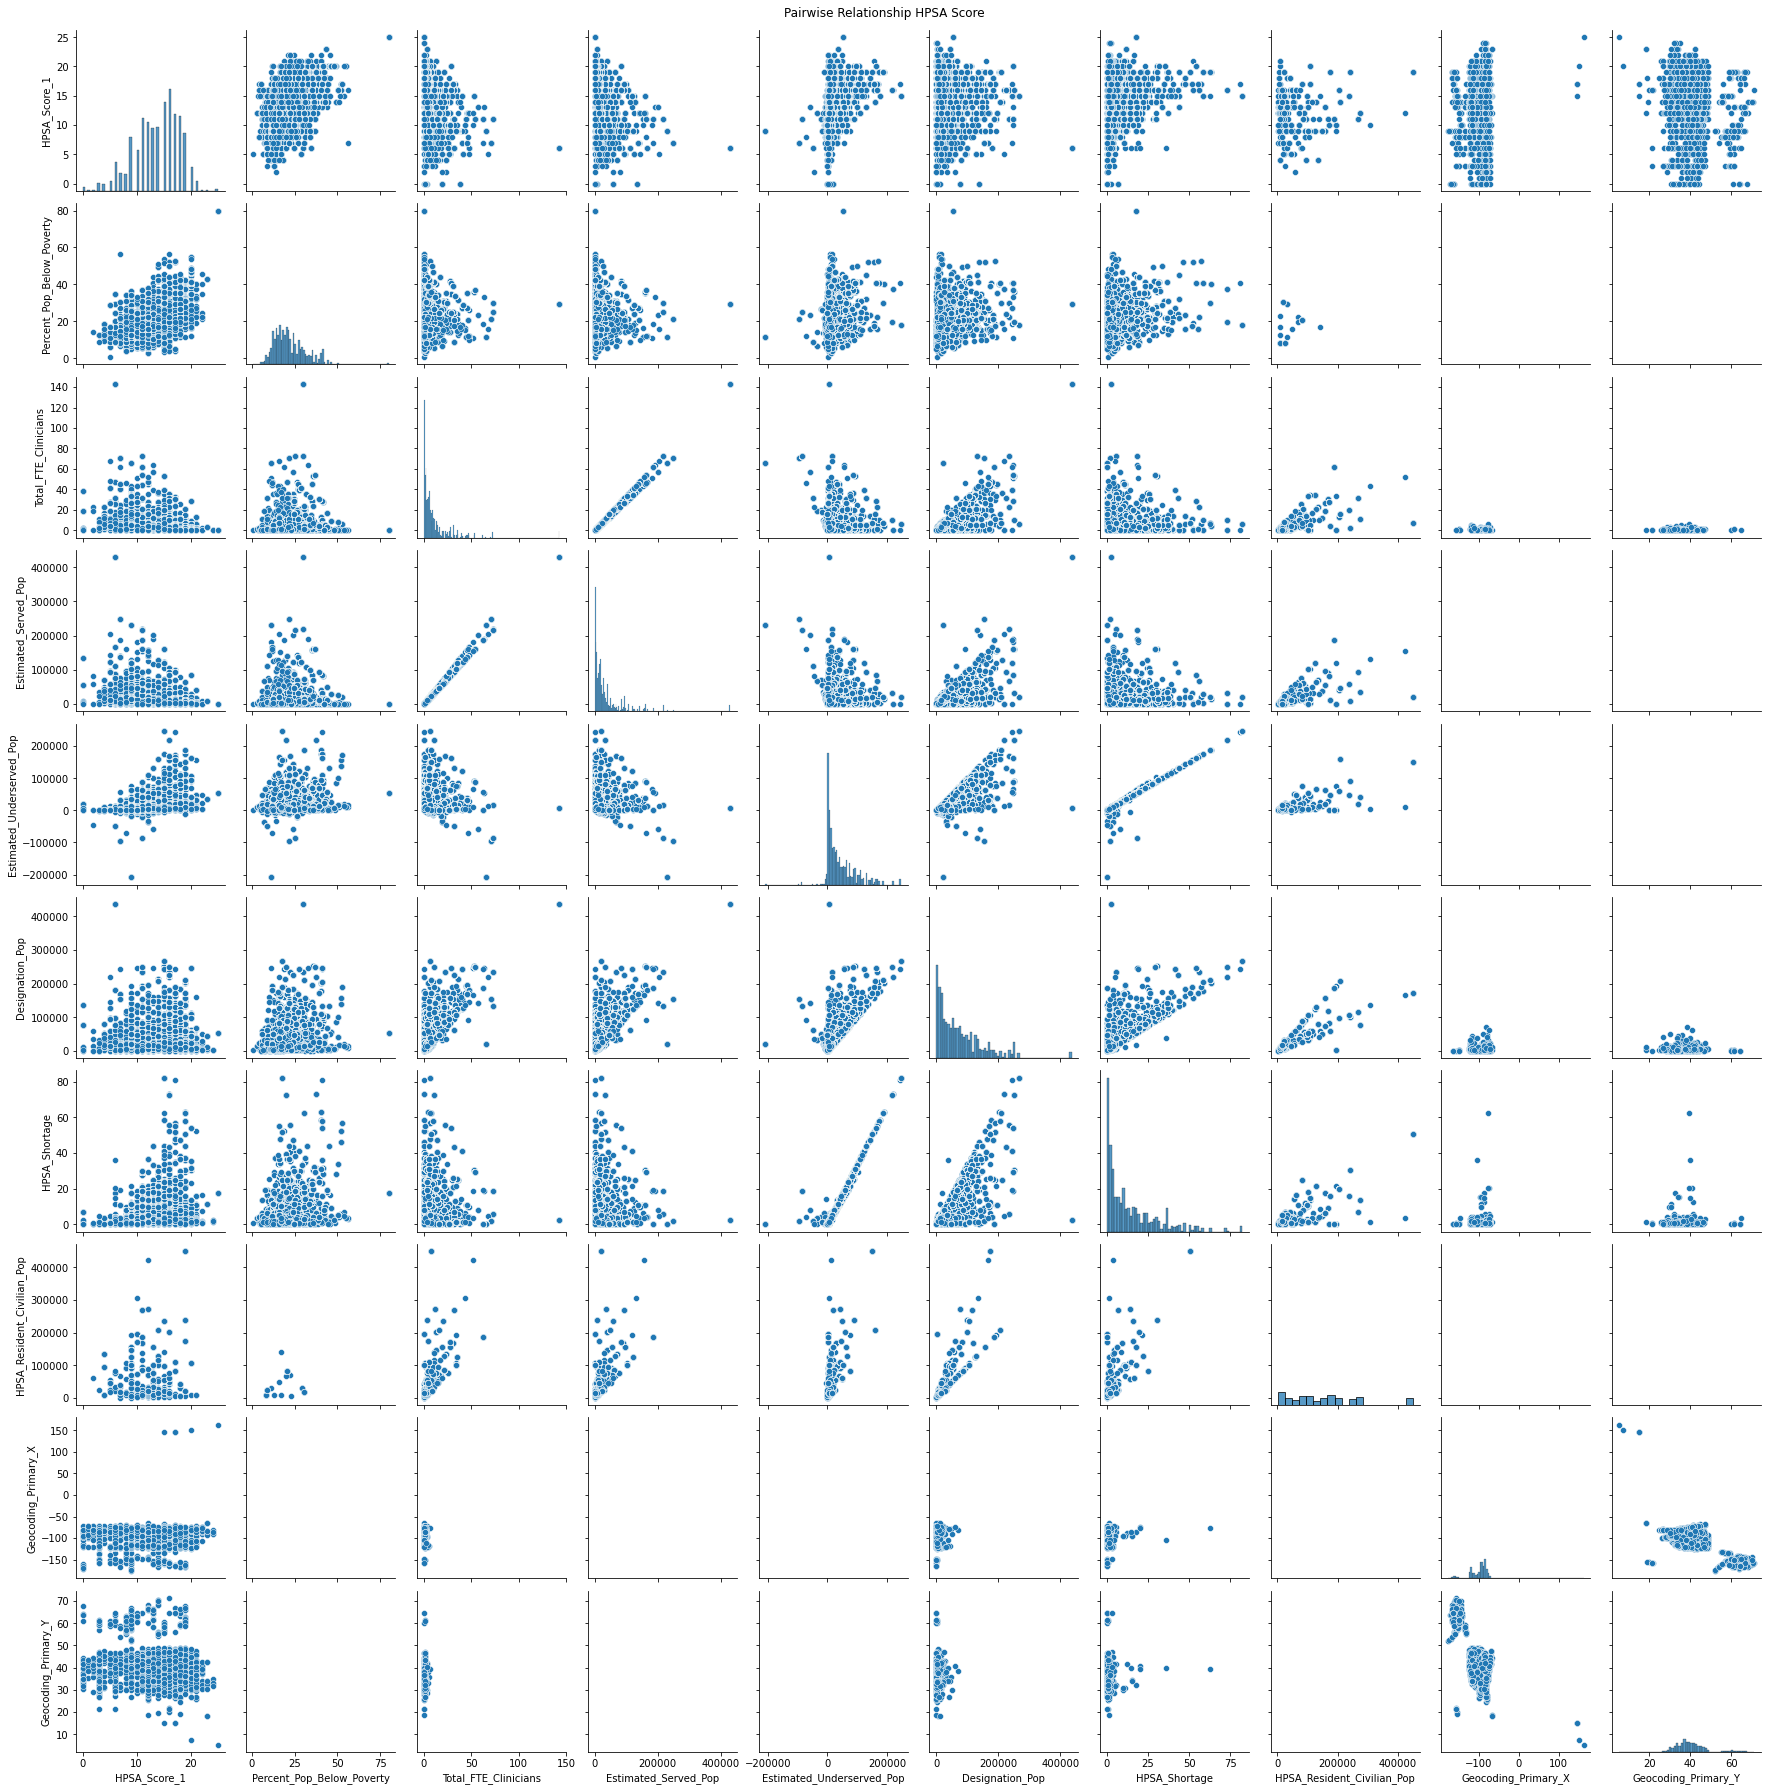

In [147]:
#split it up
s=sns.pairplot(hp_df3)
s.fig.suptitle('Pairwise Relationship HPSA Score',y=1)
plt.savefig('pairwise_plot_hpsa_score.jpg',bbox_inches='tight',dpi=300)

In [7]:
population_data='co-est2019-annres.xlsx'

In [8]:
population_df=pd.read_excel(population_data)

In [9]:
population_df

,table with row headers in column A and column headers in rows 3 through 4 (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Annual Estimates of the Resident Population fo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Geographic Area,2010-04-01 00:00:00,NaN,Population Estimate (as of July 1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Census,Estimates Base,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
3,United States,308745538,308758105,309321666,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0
4,".Autauga County, Alabama",54571,54597,54773,55227.0,54954.0,54727.0,54893.0,54864.0,55243.0,55390.0,55533.0,55869.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,"Note: The 6,222 people in Bedford city, Virgin...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3148,Suggested Citation:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3149,Annual Estimates of the Resident Population fo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3150,"Source: U.S. Census Bureau, Population Division",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
population_df=population_df.drop(index=[0,1,3146,3147,3148,3149,3150,3151])

In [11]:
population_df.set_axis(population_df.iloc[0],axis=1,inplace=True)

In [12]:
population_df.iloc[0]

2
NaN                          NaN
Census                    Census
Estimates Base    Estimates Base
2010                        2010
2011.0                    2011.0
2012.0                    2012.0
2013.0                    2013.0
2014.0                    2014.0
2015.0                    2015.0
2016.0                    2016.0
2017.0                    2017.0
2018.0                    2018.0
2019.0                    2019.0
Name: 2, dtype: object

In [13]:
population_df.drop(index=2,axis=1,inplace=True)

In [14]:
population_df.drop(index=3,axis=1,inplace=True)

In [15]:
population_df.rename(columns={np.nan:'county_state'},inplace=True)

In [16]:
population_df.county_state=population_df.county_state.str.replace('.','') 
#populatoin_df['State']=population_df.county_state.str.split(',')[1]

C:\Users\hancc\AppData\Local\Temp/ipykernel_18428/4014590986.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  population_df.county_state=population_df.county_state.str.replace('.','')


In [17]:
county=[]
state=[]
#population_df.iloc[4].county
for i in range(len(population_df.county_state)):
    pop=population_df.iloc[i].county_state.split(',')
    county.append(pop[0].replace(' County',''))
    state.append(pop[1].replace(' ',''))
    #population_df.iloc[i]['county']=county
    #print(population_df.iloc[i].county)
    #population_df.iloc[i]['state']=state

In [18]:
population_df=population_df.assign(county=county, state=state, inplace=True)

In [19]:
population_df=population_df.reset_index()

In [23]:
population_df.rename(columns={'county':'County_Name','state':'State_Name'},inplace=True)

In [25]:
hp_df2['Designation_Date']=pd.to_datetime(hp_df2['Designation_Date'],format='%Y-%m-%d')

In [26]:
hp_df2['Designation_Last_Update_Date']=pd.to_datetime(hp_df2['Designation_Last_Update_Date'],format='%Y-%m-%d')

In [27]:
hp_df2['Year']=hp_df2['Designation_Date'].dt.year

In [21]:
hp_df2['Year']

0        2017
1        2015
2        2010
3        2014
4        2013
         ... 
18086    2017
18087    2017
18088    2012
18089    2011
18090    2017
Name: Year, Length: 18091, dtype: int64

In [28]:
pop_col=list(population_df.columns)

In [243]:
#list1=[]
#for index, year in enumerate(hp_df2['Year']):
#    #pop_indexes=population_df[population_df['county']==hp_df2.iloc[index]['County_Name']].index
#    if pop_col.index(float(hp_df2.iloc[index]['Year'])):
#        ind=pop_col.index(float(hp_df2.iloc[index]['Year']))
#        for i,county in enumerate(population_df['county']):
#            if county == hp_df2.iloc[index]['County_Name']:
#                #print(county, hp_df2.iloc[index]['County_Name'] )
#                #if pop_col.index(float(hp_df2.iloc[index]['Year'])):
#                list1.append(population_df.iloc[i][pop_col[ind]])
#            else:
#                hp_df3=np.array(hp_df2[hp_df2['State_Name']==hp_df2.iloc[index]['State_Name']]['Designation_Pop'])
#                hp_df3=np.nan_to_num(hp_df3)
#                hp_df3.mean()
#                list1.append(hp_df3)
            
        #hp_df2.iloc[index]['Population']=population_df.iloc[i][year]
        #hp_df2.iloc[index]['Population']=population_df.iloc[i][year]
#    population_df[year]

In [151]:
hp_test=hp_df2.merge(population_df,on=['County_Name','State_Name'],how='left')

In [152]:
hp_test[['County_Name','State_Name','county_state','Year',2010.0,2011.0]]

,County_Name,State_Name,county_state,Year,2010,2011.0
0,Grays Harbor,Washington,"Grays Harbor County, Washington",2017,72848,72366.0
1,Brewster,Texas,"Brewster County, Texas",2015,9258,9349.0
2,Nolan,Texas,"Nolan County, Texas",2010,15244,15143.0
3,Dyer,Tennessee,"Dyer County, Tennessee",2014,38318,38118.0
4,Cambria,Pennsylvania,"Cambria County, Pennsylvania",2013,143461,142579.0
...,...,...,...,...,...,...
18086,Pima,Arizona,"Pima County, Arizona",2017,981620,988381.0
18087,Pima,Arizona,"Pima County, Arizona",2017,981620,988381.0
18088,Lawrence,Alabama,"Lawrence County, Alabama",2012,34342,34051.0
18089,Dallas,Alabama,"Dallas County, Alabama",2011,43854,43251.0


In [153]:
hp_test[hp_test['County_Name']=='Lafayette']

,Unnamed: 0,Source_ID,Source_Name,Status_Code,Status_Description,Type_Code,Type_Desc,State_Abbr,Degree_of_Shortage,Designation_Date,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,inplace
17,53,12299922H4,UNIVERSITY MEDICAL CENTER,W,Withdrawn,OFAC,Other Facility,LA,NaN,2010-05-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2287,18024,129999290I,Health Care Coalition of Lafayette County,W,Withdrawn,FQHC,Federally Qualified Health Center,MO,NaN,2013-11-01,...,33207.0,33054.0,32823.0,32619.0,32624.0,32534.0,32579.0,32542.0,32708.0,True
2289,18026,129999290G,Health Care Coalition of Lafayette County,D,Designated,FQHC,Federally Qualified Health Center,MO,NaN,2013-11-01,...,33207.0,33054.0,32823.0,32619.0,32624.0,32534.0,32579.0,32542.0,32708.0,True
2910,19833,1552727715,Lafayette County,D,Designated,Hpsa Geo,Geographic HPSA,WI,Not applicable,2017-07-21,...,16863.0,16800.0,16669.0,16777.0,16791.0,16757.0,16689.0,16672.0,16665.0,True
8558,28019,1295471016,LI-Johnson/Lafayette Counties,D,Designated,Hpsa Pop,HPSA Population,MO,Not applicable,2017-09-15,...,33207.0,33054.0,32823.0,32619.0,32624.0,32534.0,32579.0,32542.0,32708.0,True
9399,29309,1226406314,LI-Lafayette Parish,D,Designated,Hpsa Pop,HPSA Population,LA,Not applicable,2011-12-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
    hp_test.iloc[0][2017.0]

72490.0

In [155]:
list1=[]
for index, year in enumerate(hp_test['Year']):
    year_index=float(hp_test.iloc[index]['Year'])
    #print(hp_test.iloc[index]['County_Name'],year, hp_test.iloc[index][year_index])
    list1.append(hp_test.iloc[index][year_index])

In [156]:
hp_test['Population']=list1

In [157]:
hp_test1=hp_test[np.isnan(hp_test['Population'])]

In [161]:
#change the nan to 0s so that we can replace them with the designation_pop
hp_test[np.isnan(hp_test['Population'])]=0

In [178]:
#for index, population in enumerate(hp_test[hp_test['Population']==0]['Population']):
#    indices=hp_test[hp_test['Population']==0].index[index]
    #print(hp_test.iloc[indices]['Designation_Pop'])
    #hp_test.iloc[indices]['Population'].replace(0, hp_test.iloc[indices]['Designation_Pop'])
#    print(hp_test.iloc[indices]['Designation_Pop'])
    #hp_test.iloc[indices]['Population']=hp_test.iloc[indices]['Population'].replace(0.0, hp_test.iloc[indices]['Designation_Pop'])

In [174]:
#drop values where population is 0 since we have enough data points
hp_test.drop(hp_test[hp_test['Population']==0].index,inplace=True)

In [179]:
hp_test.groupby('State_Name').mean().reset_index()

,State_Name,Unnamed: 0,Designation_Pop,Estimated_Underserved_Pop,Estimated_Served_Pop,Total_FTE_Clinicians,Percent_Pop_Below_Poverty,HPSA_Score,HPSA_Shortage,CountyFIPS,...,index,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
0,Alabama,29406.025974,25159.459016,8865.954545,24559.272727,6.144352,22.597674,14.818182,3.350493,65.883117,...,36.441558,9.226036e+04,9.226464e+04,9.233778e+04,9.236445e+04,9.233229e+04,9.232886e+04,9.227400e+04,9.228774e+04,9.232634e+04
1,Arizona,35011.182909,66662.562158,36924.063042,30229.994484,9.531693,23.565819,13.862819,10.485367,15.284858,...,108.046477,2.088709e+06,2.124029e+06,2.158081e+06,2.195982e+06,2.235011e+06,2.276680e+06,2.313207e+06,2.351992e+06,2.394524e+06
2,Arkansas,34653.099291,17138.744361,11170.491935,7110.379032,2.247478,19.413445,13.489362,3.564355,77.723404,...,153.361702,1.185506e+05,1.195066e+05,1.203927e+05,1.211866e+05,1.219861e+05,1.227211e+05,1.232735e+05,1.236769e+05,1.241866e+05
3,California,31631.365618,64285.169307,37260.163150,29021.064229,9.329838,23.860543,13.062055,12.439208,45.919916,...,212.459958,4.368837e+06,4.396756e+06,4.423717e+06,4.448500e+06,4.472216e+06,4.485904e+06,4.491031e+06,4.484596e+06,4.475405e+06
4,Colorado,29519.765363,37135.910345,20264.470149,19331.298507,6.063575,19.899160,11.787709,6.431773,41.391061,...,268.821229,2.762071e+05,2.813025e+05,2.866367e+05,2.925492e+05,2.993840e+05,3.040408e+05,3.076323e+05,3.123297e+05,3.163406e+05
5,Connecticut,30334.162162,15946.783784,16754.677419,33.870968,0.011290,16.593548,13.594595,5.585484,5.918919,...,314.459459,4.868055e+05,4.882658e+05,4.887677e+05,4.890017e+05,4.880598e+05,4.869581e+05,4.861073e+05,4.859026e+05,4.850715e+05
6,Delaware,31656.500000,15774.100000,24469.833333,0.000000,0.550000,33.016667,11.916667,4.780000,3.166667,...,321.083333,4.535846e+05,4.564164e+05,4.597026e+05,4.624078e+05,4.653160e+05,4.673922e+05,4.690816e+05,4.712723e+05,4.731678e+05
7,Florida,30833.191441,69129.518563,56454.666250,15455.998750,4.997253,18.381760,16.492117,18.163405,70.807432,...,358.577703,9.942092e+05,1.008927e+06,1.022842e+06,1.038708e+06,1.056812e+06,1.076953e+06,1.093852e+06,1.106679e+06,1.116628e+06
8,Georgia,29704.615094,34939.510638,19828.571429,17664.350230,5.640180,25.225243,15.630189,6.324559,130.283019,...,454.535849,4.182074e+05,4.274587e+05,4.319409e+05,4.369810e+05,4.431826e+05,4.507805e+05,4.565425e+05,4.607454e+05,4.656501e+05
9,Hawaii,25586.939394,39115.925926,14006.423077,26598.269231,7.189286,13.161538,10.666667,4.861071,5.969697,...,552.484848,3.750700e+05,3.793219e+05,3.829883e+05,3.847658e+05,3.865736e+05,3.880172e+05,3.870751e+05,3.859711e+05,3.847606e+05


In [182]:
hp_test.to_csv('cleaned_2010-2019_data.csv')

In [222]:
for county in population_df['county']:
    if county == hp_df2.iloc[0]['County_Name']:
        print(county,county == hp_df2.iloc[index]['County_Name'] )
        print(hp_df2.iloc[0]['State_Name'])
hp_df3=np.array(hp_df2[hp_df2['State_Name']==hp_df2.iloc[0]['State_Name']]['Designation_Pop'])
hp_df3=np.nan_to_num(hp_df3)
hp_df3.mean()

Grays Harbor False
Washington


66524.94706994329

In [153]:
hp_df2.to_csv('health_shortage_filtered_2010-2019_data.csv')

In [54]:
hp_df2['County_Name'].isin(population_df.county)

1        True
2        True
3        True
5        True
6        True
         ... 
55671    True
55672    True
55673    True
55674    True
55685    True
Name: County_Name, Length: 18091, dtype: bool

In [ ]:
hp_df2.drop('Population',axis=1)

In [90]:
population_df[population_df['county']=='Wayne'].index

Int64Index([ 541,  694,  789,  885, 1112, 1316, 1481, 1597, 1747, 1890, 1989,
            2131, 2311, 2522, 2808, 3045],
           dtype='int64')

In [94]:
population_df.iloc[0][2017]


55390.0

In [148]:
population_df.to_csv('population_census.csv')

In [151]:
population_df.rename(columns={2010:'year_2010',2011.0:'year_2011',2012.0:'year_2012',2013.0:'year_2013',
                              2014.0:'year_2014',2015.0:'year_2015',2016.0:'year_2016',2017.0:'year_2017',2018.0:'year_2018'
                             ,2019.0:'year_2019'},inplace=True)

In [155]:
population_df

2,index,county_state,Census,Estimates Base,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,county,state,inplace
0,4,"Autauga County, Alabama",54571,54597,54773,55227.0,54954.0,54727.0,54893.0,54864.0,55243.0,55390.0,55533.0,55869.0,Autauga,Alabama,True
1,5,"Baldwin County, Alabama",182265,182265,183112,186558.0,190145.0,194885.0,199183.0,202939.0,207601.0,212521.0,217855.0,223234.0,Baldwin,Alabama,True
2,6,"Barbour County, Alabama",27457,27455,27327,27341.0,27169.0,26937.0,26755.0,26283.0,25806.0,25157.0,24872.0,24686.0,Barbour,Alabama,True
3,7,"Bibb County, Alabama",22915,22915,22870,22745.0,22667.0,22521.0,22553.0,22566.0,22586.0,22550.0,22367.0,22394.0,Bibb,Alabama,True
4,8,"Blount County, Alabama",57322,57322,57376,57560.0,57580.0,57619.0,57526.0,57526.0,57494.0,57787.0,57771.0,57826.0,Blount,Alabama,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,3141,"Sweetwater County, Wyoming",43806,43806,43574,43986.0,45002.0,45157.0,44948.0,44719.0,44222.0,43464.0,42858.0,42343.0,Sweetwater,Wyoming,True
3138,3142,"Teton County, Wyoming",21294,21298,21296,21414.0,21624.0,22315.0,22773.0,23047.0,23234.0,23384.0,23269.0,23464.0,Teton,Wyoming,True
3139,3143,"Uinta County, Wyoming",21118,21121,21089,20896.0,20996.0,20951.0,20822.0,20763.0,20682.0,20431.0,20292.0,20226.0,Uinta,Wyoming,True
3140,3144,"Washakie County, Wyoming",8533,8528,8530,8449.0,8409.0,8413.0,8273.0,8278.0,8165.0,8010.0,7877.0,7805.0,Washakie,Wyoming,True


In [154]:
population_df.to_csv('population_census.csv')

In [174]:
population_df.iloc[0][2017]

55390.0

In [179]:
float(hp_df2.iloc[0]['Year'])

2017.0

In [181]:
population_df.rename(columns={2010:2010.0},inplace=True)

In [183]:
list(population_df.columns)

['index',
 'county_state',
 'Census',
 'Estimates Base',
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 2017.0,
 2018.0,
 2019.0,
 'county',
 'state',
 'inplace']

In [188]:
type(pop_col[4])

float

In [180]:
population_df[2012.0]

0        54954.0
1       190145.0
2        27169.0
3        22667.0
4        57580.0
          ...   
3137     45002.0
3138     21624.0
3139     20996.0
3140      8409.0
3141      7077.0
Name: 2012.0, Length: 3142, dtype: float64

In [196]:
if pop_col.index(float(hp_df2.iloc[0]['Year'])):
    ind=pop_col.index(float(hp_df2.iloc[0]['Year']))
    print(pop_col.index(float(hp_df2.iloc[0]['Year'])))
    print(population_df.iloc[0][pop_col[ind]])

11
55390.0


In [203]:
hp_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18091 entries, 1 to 55685
Data columns (total 53 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Source_ID                          18091 non-null  object        
 1   Source_Name                        18091 non-null  object        
 2   Status_Code                        18091 non-null  object        
 3   Status_Description                 18091 non-null  object        
 4   Type_Code                          18091 non-null  object        
 5   Type_Desc                          18091 non-null  object        
 6   State_Abbr                         18091 non-null  object        
 7   Degree_of_Shortage                 15688 non-null  object        
 8   Designation_Date                   18091 non-null  datetime64[ns]
 9   Designation_Last_Update_Date       18091 non-null  datetime64[ns]
 10  Designation_Pop                   